# Import libraries

In [7]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso, Ridge, LassoLars, BayesianRidge, ARDRegression, PassiveAggressiveRegressor
from sklearn.linear_model import HuberRegressor, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from collections import Counter
from pandas.api.types import is_numeric_dtype
from scipy.stats import randint
from scipy.stats import skew
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from enum import Enum
import numpy as np
import random

# Load data

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

# Pre-process data

In [3]:
y = np.log(train_data["SalePrice"])
X = train_data.drop(labels="SalePrice", axis=1)
X_test = test_data

pd.set_option("display.max_rows",100)

def analyse(data, test, labels):
    analysisTable = pd.DataFrame(data.columns, columns=["Columns"])
    analysisTable["Data Type"] = ""
    analysisTable["Unique Values"] = ""
    analysisTable["Total Values"] = ""
    analysisTable["Empty Values"] = ""
    analysisTable["Empty %"] = ""
    analysisTable["Correlation %"] = ""
    analysisTable["Feature Type"] = ""
    analysisTable["Category Relevant"] = ""
    analysisTable["Decision"] = ""
    
    finalTable = np.zeros(shape=(len(data) + len(test),))
    data_process = data.append(test)
    
    label_encoder = LabelEncoder()
    binarizer = LabelBinarizer()
    scaler = StandardScaler()
    
    count = 0
    
    for i in data:
        column = data[i]
        
        row_count = len(data)
        data_type = column.dtype
        empty_values = column.isnull().sum()
        empty_perc = empty_values / row_count
        total_values = row_count - empty_values
        unique_values = column.nunique()
        unique_perc = unique_values / total_values
        corr_perc = 0
        
        analysisTable["Data Type"][count] = data_type
        analysisTable["Unique Values"][count] = unique_values
        analysisTable["Total Values"][count] = total_values
        analysisTable["Empty Values"][count] = empty_values
        analysisTable["Empty %"][count] = empty_perc

        if is_numeric_dtype(column):
            corr_perc = data[column.name].corr(labels)
            analysisTable["Correlation %"][count] = corr_perc
        
        # Work out whether the feature is numerical, categorical, ordinal or text
        if data_type == "float64":
            analysisTable["Feature Type"][count] = "Numerical"
        elif unique_perc <= 0.02:
            if abs(corr_perc) >= 0.25:
                analysisTable["Feature Type"][count] = "Ordinal"
            else:
                analysisTable["Feature Type"][count] = "Categorical"
        elif data_type == "int64":
            analysisTable["Feature Type"][count] = "Numerical"
        else:
            analysisTable["Feature Type"][count] = "Text"
        
        # Decide on what we should do with this feature
        if empty_perc > 0.2:
            analysisTable["Decision"][count] = "Drop"
        elif analysisTable["Feature Type"][count] == "Numerical" and abs(corr_perc) < 0.05:
            analysisTable["Decision"][count] = "Drop"
        elif analysisTable["Feature Type"][count] == "Categorical":
            analysisTable["Decision"][count] = "One-Hot Encode"
        elif is_numeric_dtype(column) or analysisTable["Feature Type"][count] == "Ordinal":
            analysisTable["Decision"][count] = "Scale"
        else:
            analysisTable["Decision"][count] = "Drop"

        # Process the column (if it's not being dropped)
        action = analysisTable["Decision"][count]
        value = ""
        col_process = data_process[i]
       
        if action == "One-Hot Encode":
            col_process.fillna(col_process.value_counts().idxmax(), inplace=True)
            
            if data_type == "object":
                object_labels = label_encoder.fit_transform(col_process)
                corr_perc = pd.DataFrame(object_labels)[0].corr(labels)
                
                analysisTable["Correlation %"][count] = corr_perc
            
            if abs(corr_perc) >= 0.25:
                analysisTable["Feature Type"][count] = "Ordinal"
                analysisTable["Decision"][count] = "Scale"

                skewed_value = skew(object_labels)

                if skewed_value > 0.75:
                    object_labels = np.log1p(object_labels)


                value = scaler.fit_transform(object_labels.reshape(-1, 1))
            else:
                one_hot = binarizer.fit_transform(col_process)

                category_compare = pd.DataFrame(one_hot)
                value = np.zeros(shape = (len(data) + len(test),))

                for cat in category_compare:
                    encoded_cat = category_compare[cat]
                    cat_corr = encoded_cat.corr(labels)

                    if np.abs(cat_corr) > 0.05:
                        value = np.c_[value, encoded_cat]

                if np.ndim(value) <= 1:
                    analysisTable["Category Relevant"][count] = "No"
                    analysisTable["Decision"][count] = "Drop"
                    action = "Drop"
                else:
                    analysisTable["Category Relevant"][count] = "Yes"
            
        elif action == "Scale":
            col_process.fillna(col_process.mean(), inplace=True)
            
            skewed_value = skew(col_process)
           
            if skewed_value > 0.75:
                col_process = np.log1p(col_process)

            
            value = scaler.fit_transform(col_process.values.reshape(-1, 1))
            
        if action != "Drop":
            finalTable = np.c_[finalTable, value]
        
        count += 1
        
    processed_train = finalTable[:len(data)]
    
    # Detect outliers
#     ols = sm.OLS(labels, processed_train)
#     results = ols.fit()
#     bonf_test = results.outlier_test()['bonf(p)']
#     bonf_outlier = list(bonf_test[bonf_test<1e-3].index) 
#     processed_train = processed_train[bonf_test>=1e-3]
#     print(bonf_test[bonf_test<1e-3])
#     print(processed_train.shape)
    
#     labels = labels[bonf_test>=1e-3]

    processed_test = finalTable[len(data):]

    return analysisTable, processed_train, processed_test, labels

analysis, X, X_test, y = analyse(X, X_test, y)
analysis

C:\Users\Dave\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,Columns,Data Type,Unique Values,Total Values,Empty Values,Empty %,Correlation %,Feature Type,Category Relevant,Decision
0,Id,int64,1460,1460,0,0,-0.0179424,Numerical,,Drop
1,MSSubClass,int64,15,1460,0,0,-0.073959,Categorical,Yes,One-Hot Encode
2,MSZoning,object,5,1460,0,0,-0.18886,Categorical,Yes,One-Hot Encode
3,LotFrontage,float64,110,1201,259,0.177397,0.355878,Numerical,,Scale
4,LotArea,int64,1073,1460,0,0,0.25732,Numerical,,Scale
5,Street,object,2,1460,0,0,0.0573692,Categorical,Yes,One-Hot Encode
6,Alley,object,2,91,1369,0.937671,,Text,,Drop
7,LotShape,object,4,1460,0,0,-0.278091,Ordinal,,Scale
8,LandContour,object,4,1460,0,0,0.0323402,Categorical,Yes,One-Hot Encode
9,Utilities,object,2,1460,0,0,-0.0126321,Categorical,No,Drop


In [4]:
X.shape

(1460, 211)

# Train data

In [5]:
class ModelWrapper:
    def __init__(self, name, model, model_type):
        self.name = name
        self.model = model
        self.model_type = model_type
        self.cv_score = 0
        self.mean_cv_score = 0
        self.training_score = 0
        self.model_score = 0
        self.selected = False
        self.predictions = None
        
    def evaluate(self, X, y):
        self.cv_score = cross_val_score(self.model, X, y, cv = 5)
        self.mean_cv_score = np.mean(self.cv_score)
        self.model.fit(X, y)
        self.training_score = self.model.score(X, y)
        
    def process_results(self, X, y):
        print("======================================================================================")
        print(self.name)
        self.evaluate(X, y)
        print("Cross validation scores:", self.cv_score)
        print("Mean cross validation score:", self.mean_cv_score)
        print("Score on training set:", self.training_score)

class ModelType(Enum):
    Linear = 1
    Ensemble = 2

In [8]:
random_state = 23

models = []

# Linear models
models.append(ModelWrapper("ElasticNet", ElasticNet(alpha=0.001, random_state = random_state), ModelType.Linear))
models.append(ModelWrapper("Lasso", Lasso(alpha=0.001, random_state = random_state), ModelType.Linear))
models.append(ModelWrapper("Ridge", Ridge(random_state = random_state), ModelType.Linear))
models.append(ModelWrapper("KernelRidge", KernelRidge(alpha = 0.001), ModelType.Linear))
models.append(ModelWrapper("LassoLars", LassoLars(alpha = 0.001), ModelType.Linear))
models.append(ModelWrapper("BayesianRidge", BayesianRidge(), ModelType.Linear))
models.append(ModelWrapper("PassiveAggressiveRegressor", PassiveAggressiveRegressor(random_state = random_state, max_iter=1000), ModelType.Linear))

# Ensemble models
models.append(ModelWrapper("RandomForestRegressor", RandomForestRegressor(random_state = random_state), ModelType.Ensemble))
models.append(ModelWrapper("GradientBoostingRegressor", GradientBoostingRegressor(random_state = random_state), ModelType.Ensemble))
models.append(ModelWrapper("XGBRegressor", XGBRegressor(seed = random_state), ModelType.Ensemble))
models.append(ModelWrapper("ExtraTreesRegressor", ExtraTreesRegressor(random_state = random_state), ModelType.Ensemble))
models.append(ModelWrapper("BaggingRegressor", BaggingRegressor(random_state = random_state), ModelType.Ensemble))

for model in models:
    model.process_results(X, y) 


ElasticNet
Cross validation scores: [ 0.92958794  0.90420661  0.90625409  0.91129334  0.86422653]
Mean cross validation score: 0.903113701449
Score on training set: 0.921629483202
Lasso
Cross validation scores: [ 0.92897946  0.89694523  0.90482991  0.90869088  0.85766943]
Mean cross validation score: 0.899422982228
Score on training set: 0.914156845126
Ridge
Cross validation scores: [ 0.92462986  0.90324185  0.90093095  0.90769788  0.86010868]
Mean cross validation score: 0.899321844549
Score on training set: 0.931542668463
KernelRidge
Cross validation scores: [ 0.91250263  0.76310991  0.86987452  0.89989042  0.85757228]
Mean cross validation score: 0.860589951013
Score on training set: 0.932792648202
LassoLars
Cross validation scores: [ 0.85867798  0.84478557  0.83982044  0.85208332  0.81259714]
Mean cross validation score: 0.841592889303
Score on training set: 0.84002702187
BayesianRidge
Cross validation scores: [ 0.9269984   0.90334328  0.90647261  0.91094242  0.86136169]
Mean cross

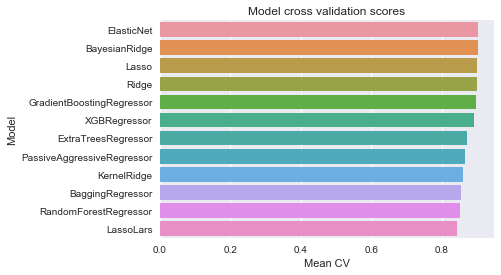

In [9]:
# Convert list of models to a pandas dataframe
chart_df = pd.DataFrame([vars(m) for m in models])
chart_df = chart_df.sort_values("mean_cv_score", ascending=False)

# Draw chart
chart = sns.barplot("mean_cv_score", "name", data = chart_df, orient = "h")
chart.set_xlabel("Mean CV")
chart.set_ylabel("Model")
chart.set_title("Model cross validation scores")

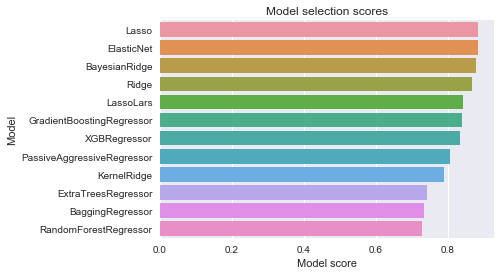

In [10]:
# Evaluate best models by penalising models that overfit
for model in models:
    model.model_score = model.mean_cv_score - (model.training_score - model.mean_cv_score)

# Convert list of models to a pandas dataframe
chart_df = pd.DataFrame([vars(m) for m in models])
chart_df = chart_df.sort_values("model_score", ascending=False)

# Draw chart
chart = sns.barplot("model_score", "name", data = chart_df, orient = "h")
chart.set_xlabel("Model score")
chart.set_ylabel("Model")
chart.set_title("Model selection scores")

In [11]:
# Automatic model selection (top 2 of each model type, as they are already sorted by model_score)
best_models = chart_df[chart_df["model_type"] == ModelType.Linear].head(2)
best_models = best_models.append(chart_df[chart_df["model_type"] == ModelType.Ensemble].head(2))
best_models["name"]

for model in models:
    for best in best_models["name"]:
        if best == model.name:
            model.selected = True
            model.predictions = model.model.predict(X_test)
            model.predictions = np.exp(model.predictions)
            print(model.predictions)


[ 119226.3457642   156245.34405711  181777.87481282 ...,  175722.77736754
  118406.60507331  227092.15468411]
[ 118853.9521099   157905.76238621  182365.95138279 ...,  172448.43682828
  121093.80606735  232900.46944589]
[ 120421.45828757  151721.64248083  180381.6033047  ...,  160661.73376574
  121529.47723707  241551.42589076]
[ 120619.5390625  156062.46875    183084.21875   ...,  161845.765625
  120674.9921875  237003.390625 ]


# Save predictions

In [112]:
model_df = pd.DataFrame([vars(m) for m in models])
model_df = model_df[model_df["selected"] == True]
model_df = model_df.sort_values("model_score", ascending=False)

model_weight = len(model_df)
prediction_values = []
prediction_scores = []

for index, row in model_df.iterrows():
    weight = 0.1 * model_weight
    model_weight -= 1
    prediction_values.append(row["predictions"])
    prediction_scores.append(row["model_score"] * weight)
    
prediction_weights = np.array(prediction_scores) / sum(prediction_scores)
prediction_weights

predictions = 0.

for i in range(len(prediction_weights)):
    predictions += prediction_weights[i] * prediction_values[i]

submission = pd.DataFrame({ "Id": test_data["Id"] })
submission["SalePrice"] = predictions

submission.to_csv("_dave_submit.csv", index=False)